# 🎧 Comparación de hábitos de escucha musical entre dos ciudades

Este análisis busca identificar diferencias en los hábitos de escucha musical entre usuarios de dos ciudades distintas, Springfield y Shelbyville, con base en datos de Spotify.

📅 **Objetivo**:  
Determinar si existen diferencias significativas en el comportamiento de los usuarios según la ciudad y el día de la semana.


## 1. 📚 Importación de librerías


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

## 2. 📄 Carga y descripción de los datos

In [2]:
# Cargar dataset
df = pd.read_csv('../data/music_project_en.csv')

# Vista general
df.head()


,userID,Track,artist,genre,City,time,Day
0,FFB692EC,Kamigata To Boots,The Mass Missile,rock,Shelbyville,20:28:33,Wednesday
1,55204538,Delayed Because of Accident,Andreas Rönnberg,rock,Springfield,14:07:09,Friday
2,20EC38,Funiculì funiculà,Mario Lanza,pop,Shelbyville,20:58:07,Wednesday
3,A3DD03C9,Dragons in the Sunset,Fire + Ice,folk,Shelbyville,08:37:09,Monday
4,E2DC1FAE,Soul People,Space Echo,dance,Springfield,08:34:34,Monday


In [3]:
# Tamaño del dataset y tipos de datos
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65079 entries, 0 to 65078
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0     userID  65079 non-null  object
 1   Track     63736 non-null  object
 2   artist    57512 non-null  object
 3   genre     63881 non-null  object
 4     City    65079 non-null  object
 5   time      65079 non-null  object
 6   Day       65079 non-null  object
dtypes: object(7)
memory usage: 3.5+ MB


📌 Obervaciones:

- El tipo de datos es object para todas la columnas, lo cual es un error ya que la columna `time` no corresponde al tipo de datos.
- Algunos encabezados están en mayúsculas, otros en minúsculas.
- Hay espacios en algunos encabezados.
- Hay valores ausentes en 3 columnas (`Track`, `artist` y `genre`)

## 3. 🔃 Preprocesamiento de datos

Se prepararán los datos para ser procesados resolviendo los problemas encontrados anteriormente.

### Correción de errores en nombres de columnas

In [4]:
# Se confirman los errores

df.columns

Index(['  userID', 'Track', 'artist', 'genre', '  City  ', 'time', 'Day'], dtype='object')

In [5]:
# Corrección de errores

df.columns = (
    df.columns
    .str.strip()         # elimina espacios iniciales/finales
    .str.lower()         # convierte todo a minúsculas
    .str.replace(' ', '_')  # reemplaza espacios por guión bajo
)

In [6]:
# Se observa que tambien es necesario utilizar la regla e snake_case a la columna userid (debe ser user_id)

df = df.rename(columns={'userid': 'user_id'})

In [7]:
# Se confirma la correccción en los nombres de las columnas

df.columns

Index(['user_id', 'track', 'artist', 'genre', 'city', 'time', 'day'], dtype='object')

### Analizar los valores ausentes y duplicados.

In [8]:
# Revisión de valores nulos
df.isnull().sum()

user_id       0
track      1343
artist     7567
genre      1198
city          0
time          0
day           0
dtype: int64

No todos los valores ausentes afectan a la investigación. Por ejemplo, los valores ausentes en track y artist no son cruciales. Simplemente se reemplazarán con valores predeterminados como el string 'unknown' (desconocido).

Pero los valores ausentes en 'genre' pueden afectar la comparación entre las preferencias musicales de Springfield y Shelbyville. 

Dado que en este proyecto no es posible descubrir las razones por las cuales hay datos ausentes en la columna 'genre' y tampoco es posible intentar recuperarlos, simplemente se rellenarán estos valores ausentes con un valor predeterminado y se evaluará cuánto podrían afectar los valores ausentes al análisis.

In [9]:
# Reemplazo de valores ausentes en las columnas 'track', 'artist' y 'genre'.

columns_to_replace = ['track', 'artist', 'genre']

for col in columns_to_replace:
    df.fillna('unknown', inplace=True)# escribe tu código aquí

print(df.isna().sum())

user_id    0
track      0
artist     0
genre      0
city       0
time       0
day        0
dtype: int64


#### Validación de duplicados explícitos

Antes de eliminar posibles duplicados del conjunto de datos, se realiza una validación completa para asegurarse de que las filas marcadas como duplicadas sean realmente idénticas en todas sus columnas. Este paso es fundamental para evitar eliminar información valiosa por error.

✅ Criterios para considerar una fila como duplicado explícito real:

1. La fila debe ser idéntica en **todas las columnas**.
2. No debe haber diferencias invisibles (espacios, tildes, codificación especial).
3. No debe haber columnas ocultas o irrelevantes que generen confusión.
4. El índice del DataFrame debe estar limpio y sin duplicados.



In [10]:
# Conteo de filas duplicadas explícitas (según todas las columnas)
duplicados_explicitos = df.duplicated().sum()
print(f'Cantidad de duplicados explícitos detectados: {duplicados_explicitos}')


Cantidad de duplicados explícitos detectados: 3826


In [11]:
# Mostrar todas las filas que están duplicadas (originales + copias)
duplicados = df[df.duplicated(keep=False)]

# Ordenarlos para agrupar visualmente los bloques duplicados
duplicados_sorted = duplicados.sort_values(by=df.columns.tolist())

# Mostrar un subconjunto para revisar visualmente
duplicados_sorted.head(20)


,user_id,track,artist,genre,city,time,day
15410,1001CE90,Invasion,Nick Arundel,videogame,Springfield,09:35:01,Monday
39981,1001CE90,Invasion,Nick Arundel,videogame,Springfield,09:35:01,Monday
4542,100261F9,Jump,Kris Kross,hip,Springfield,14:42:21,Friday
64923,100261F9,Jump,Kris Kross,hip,Springfield,14:42:21,Friday
3845,10189D10,Alia Aventuro,La Perdita Generacio,pop,Shelbyville,09:07:49,Wednesday
18944,10189D10,Alia Aventuro,La Perdita Generacio,pop,Shelbyville,09:07:49,Wednesday
7051,10189D10,Jolene,Hey Ocean!,alternative,Shelbyville,09:42:17,Wednesday
56707,10189D10,Jolene,Hey Ocean!,alternative,Shelbyville,09:42:17,Wednesday
517,10189D10,Kontra krusadanto,Dochamar,pop,Shelbyville,14:34:24,Monday
39972,10189D10,Kontra krusadanto,Dochamar,pop,Shelbyville,14:34:24,Monday


##### ✅ Justificación

Se observaron manualmente las primeras filas duplicadas y se confirmó que:

- Son completamente idénticas en **todas las columnas**, incluyendo `user_id`, `track`, `artist`, `genre`, `city`, `time`, y `day`.
- No existen diferencias invisibles como espacios o mayúsculas.
- El índice también está limpio (sin duplicación estructural).

Dado que estas filas no aportan nueva información y podrían distorsionar los resultados del análisis (como conteos, promedios, etc.), se eliminarán de forma segura.


In [12]:
# Eliminación de duplicados explícitos
df = df.drop_duplicates().reset_index(drop=True)
print("Duplicados eliminados. Dimensiones del DataFrame limpio:", df.shape)

Duplicados eliminados. Dimensiones del DataFrame limpio: (61253, 7)


#### Validación de duplicados implícitos

Se realizará una verificación de valores únicos en las columnas `'genre'`, `'day'` y `'city'` con el objetivo de identificar posibles duplicados implícitos. Estos ocurren cuando una misma categoría aparece escrita de diferentes formas (por ejemplo: `'hip'`, `'hip-hop'`, `'hiphop'`), lo que puede afectar los análisis por grupo.

Se eligieron estas tres columnas porque:

- Son campos categóricos de texto libre o limitado.
- Pueden contener errores de escritura, espacios innecesarios o variaciones en mayúsculas/minúsculas.
- Su consistencia es clave para obtener resultados correctos al agrupar o contar registros.

Las demás columnas del dataset (como `'user_id'`, `'track'`, `'artist'`, `'time'`) **no se consideran candidatas a corrección**, ya que:
- Representan entidades únicas o identificadores que **no deben agruparse aunque se parezcan**.
- Modificarlas podría conducir a pérdida de información o interpretación incorrecta de los datos.

Por lo tanto, la limpieza de duplicados implícitos se aplicará exclusivamente a `'genre'`, `'day'` y `'city'`, y solo si se detectan valores inconsistentes en cada una.



In [13]:
# Se verifican valores unicos

columnas_revisar = ['genre', 'day', 'city']

for col in columnas_revisar:
    print(f"\nValores únicos en '{col}':")
    print(sorted(df[col].unique()))


Valores únicos en 'genre':
['acid', 'acoustic', 'action', 'adult', 'africa', 'afrikaans', 'alternative', 'ambient', 'americana', 'animated', 'anime', 'arabesk', 'arabic', 'arena', 'argentinetango', 'art', 'audiobook', 'avantgarde', 'axé', 'baile', 'balkan', 'beats', 'bigroom', 'black', 'bluegrass', 'blues', 'bollywood', 'bossa', 'brazilian', 'breakbeat', 'breaks', 'broadway', 'cantautori', 'cantopop', 'canzone', 'caribbean', 'caucasian', 'celtic', 'chamber', 'children', 'chill', 'chinese', 'choral', 'christian', 'christmas', 'classical', 'classicmetal', 'club', 'colombian', 'comedy', 'conjazz', 'contemporary', 'country', 'cuban', 'dance', 'dancehall', 'dancepop', 'dark', 'death', 'deep', 'deutschrock', 'deutschspr', 'dirty', 'disco', 'dnb', 'documentary', 'downbeat', 'downtempo', 'drum', 'dub', 'dubstep', 'eastern', 'easy', 'electronic', 'electropop', 'emo', 'entehno', 'epicmetal', 'estrada', 'ethnic', 'eurofolk', 'european', 'experimental', 'extrememetal', 'fado', 'film', 'fitness', 

📌 Justificación:

Dado que `'day'` y `'city'` tienen una cantidad reducida de categorías controladas (días de la semana y solo dos ciudades), **es poco probable que contengan errores de escritura significativos**.  
En cambio, `'genre'` tiene un número considerablemente mayor de valores únicos, lo que indica **posibles errores o inconsistencias** (como `'hip'`, `'hop'`, `'hip-hop'`) que **sí requieren limpieza**.

Por lo tanto, la revisión de duplicados implícitos se enfocará únicamente en la columna `'genre'`.


##### 🎵 Limpieza de duplicados implícitos en el campo `'genre'`

En esta etapa del análisis, nos enfocaremos en la columna `'genre'`, ya que se identificó como una de las más propensas a contener **duplicados implícitos**, es decir, valores que representan el mismo género musical pero están escritos de manera distinta (por ejemplo: `'hip'`, `'hop'`,  `'hip-hop'`, `'hiphop'`).

Este tipo de inconsistencias puede afectar directamente los resultados del análisis, ya que fragmenta las categorías y distorsiona los conteos por género.  
Por lo tanto, es importante detectar y corregir estos valores antes de continuar.

El primer paso es mostrar los nombres únicos de géneros presentes en el dataset, ordenados alfabéticamente. Esto nos permitirá identificar manualmente posibles errores de escritura o variaciones del mismo término.


In [14]:
# Mostrar todos los géneros únicos
sorted(df['genre'].dropna().unique())


['acid',
 'acoustic',
 'action',
 'adult',
 'africa',
 'afrikaans',
 'alternative',
 'ambient',
 'americana',
 'animated',
 'anime',
 'arabesk',
 'arabic',
 'arena',
 'argentinetango',
 'art',
 'audiobook',
 'avantgarde',
 'axé',
 'baile',
 'balkan',
 'beats',
 'bigroom',
 'black',
 'bluegrass',
 'blues',
 'bollywood',
 'bossa',
 'brazilian',
 'breakbeat',
 'breaks',
 'broadway',
 'cantautori',
 'cantopop',
 'canzone',
 'caribbean',
 'caucasian',
 'celtic',
 'chamber',
 'children',
 'chill',
 'chinese',
 'choral',
 'christian',
 'christmas',
 'classical',
 'classicmetal',
 'club',
 'colombian',
 'comedy',
 'conjazz',
 'contemporary',
 'country',
 'cuban',
 'dance',
 'dancehall',
 'dancepop',
 'dark',
 'death',
 'deep',
 'deutschrock',
 'deutschspr',
 'dirty',
 'disco',
 'dnb',
 'documentary',
 'downbeat',
 'downtempo',
 'drum',
 'dub',
 'dubstep',
 'eastern',
 'easy',
 'electronic',
 'electropop',
 'emo',
 'entehno',
 'epicmetal',
 'estrada',
 'ethnic',
 'eurofolk',
 'european',
 'expe

Tras analizar los valores únicos en la columna `'genre'`, se detectó que el género **hiphop** aparece en el dataset representado por distintas variaciones: 'hip', 'hip-hop' y 'hiphop'.

Estas variaciones son inconsistencias en la escritura del mismo género musical, lo que genera fragmentación innecesaria en el análisis.  
Dado que `'hiphop'` es el valor más representativo y consistente, se decidió **unificar todos los casos bajo este término**, aplicando una corrección puntual en el dataset.

Se validó que no existen otras categorías similares con esta problemática, por lo que **no fue necesario aplicar corrección a ningún otro género**.


In [15]:
# Mostrar cuantas veces aparecen antes del reemplazo
print("Conteo de variantes antes de la corrección:")
print(df['genre'].value_counts().loc[['hip', 'hop', 'hip-hop', 'hiphop']])

Conteo de variantes antes de la corrección:
genre
hip        2975
hop           1
hip-hop       1
hiphop       79
Name: count, dtype: int64


In [16]:
# Reemplazo explícito de variantes incorrectas
df['genre'] = df['genre'].replace(['hip', 'hop', 'hip-hop'], 'hiphop')


In [17]:
# Mostrar cuantas veces aparecen despúes del reemplazo
print("Conteo de 'hiphop' después de la corrección:")
print(df['genre'].value_counts().loc[['hiphop']])

Conteo de 'hiphop' después de la corrección:
genre
hiphop    3056
Name: count, dtype: int64


## 4. 🔬 Análisis exploratorio de datos 
> Hipótesis: "¿Los usuarios de Springfield y Shelbyville consumen música de forma diferente los lunes, miércoles y viernes?"

La hipótesis afirma que existen diferencias en la forma en que los usuarios y las usuarias de Springfield y Shelbyville consumen música. Para comprobar esto, se utilizarán los datos de tres días de la semana: 

- Lunes 
- Miércoles
- Viernes

### 📊 Calcular promedio de canciones por usuario, por ciudad y día:

In [18]:
# Agrupar por día, ciudad y usuario → contar reproducciones por usuario

def promedio_por_usuario(df, dias):
    user_activity = df[df['day'].isin(dias)].groupby(['day', 'city', 'user_id']).size().reset_index(name='reproducciones')
    return user_activity.groupby(['day', 'city'])['reproducciones'].mean().unstack()

dias = ['Monday', 'Wednesday', 'Friday']
promedios = promedio_por_usuario(df, dias)
print("🎵 Promedio de canciones reproducidas por usuario:")
display(promedios)



🎵 Promedio de canciones reproducidas por usuario:


city,Shelbyville,Springfield
day,,
Friday,1.311457,1.312886
Monday,1.321563,1.322245
Wednesday,1.339518,1.318073


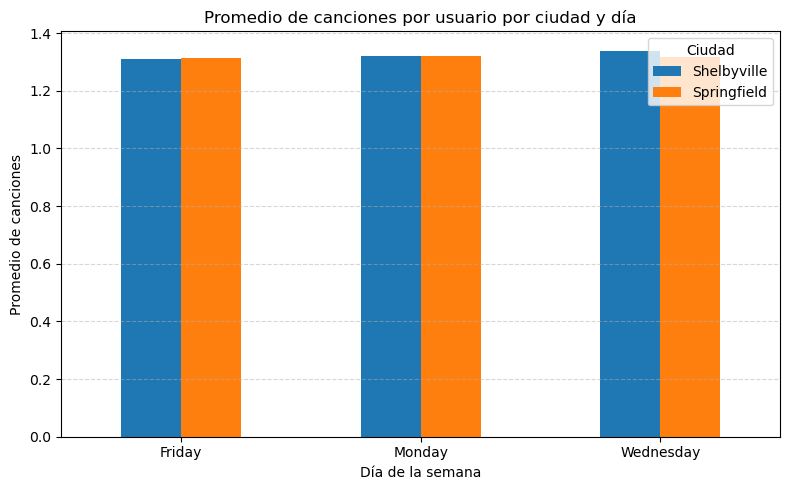

In [19]:
# Visulaización

promedios.plot(kind='bar', figsize=(8, 5))
plt.title('Promedio de canciones por usuario por ciudad y día')
plt.ylabel('Promedio de canciones')
plt.xlabel('Día de la semana')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Ciudad')
plt.tight_layout()
plt.show()


## 🎯 Conclusión: 

### **Comparación de hábitos de escucha por ciudad y día**

Para evaluar la hipótesis de que los usuarios de Springfield y Shelbyville tienen diferentes comportamientos de escucha los lunes, miércoles y viernes, se analizó el promedio de canciones reproducidas por usuario en cada ciudad por día.

Esto permite eliminar el sesgo que podría generarse por diferencias en la cantidad total de usuarios entre ciudades, enfocándose directamente en los hábitos individuales.

El análisis reveló que:

El promedio de canciones por usuario en ambos grupos es prácticamente idéntico.

Las diferencias entre días y ciudades no superan los 0.03 tracks por usuario, lo que es estadísticamente y prácticamente despreciable.

📊 Esta evidencia sugiere que, en términos de comportamiento promedio, no hay una diferencia significativa entre los usuarios de ambas ciudades en los días analizados.
La mayor cantidad total de reproducciones observada previamente en Springfield se debe probablemente a un mayor número de usuarios, no a un mayor consumo por persona.

